In [1]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
from pyproj import Transformer
from rasterio.crs import CRS
from tqdm import tqdm
import concurrent.futures
import numpy as np

This table has the change type! 

In [2]:
df_site_subset = gpd.read_file('../3_dist_sites/sites_for_processing_may_2024.geojson')
df_site_subset.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,POINT (48.77698 31.75490)
2,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,POINT (36.61178 35.52891)
3,30,noChange,No Change,NaT,NaT,31SDU,POINT (2.98892 34.90057)
4,34,VLmin,Wetland,2021-10-22,2021-10-08,13QFC,POINT (-103.52487 20.04769)


This one has the burst id!

In [3]:
df_site_with_burst = gpd.read_file('val_sites_subset.geojson')
df_site_with_burst.head()

,site_id,change_label,change_time,last_observation_time,jpl_burst_id,geometry
0,4,VLmaj,2021-11-07,2021-11-02,T036-076228-IW3,POINT (19.33289 4.57490)
1,13,VLmaj,2021-10-03,NaT,T108-230715-IW2,POINT (48.77698 31.75490)
2,13,VLmaj,2021-10-03,NaT,T101-214979-IW1,POINT (48.77698 31.75490)
3,22,VLmin,2021-12-19,2021-12-12,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,2021-12-19,2021-12-12,T021-043823-IW2,POINT (36.61178 35.52891)


In [4]:
df_subset_final = pd.merge(df_site_subset, df_site_with_burst[['site_id', 'jpl_burst_id']], on='site_id')
df_subset_final.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry,jpl_burst_id
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.57490),T036-076228-IW3
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,POINT (48.77698 31.75490),T108-230715-IW2
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,POINT (48.77698 31.75490),T101-214979-IW1
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,POINT (36.61178 35.52891),T014-028130-IW2
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,POINT (36.61178 35.52891),T021-043823-IW2


In [5]:
df_subset_final.to_file('val_sites_subset_with_all_metadata.geojson', driver='GeoJSON')

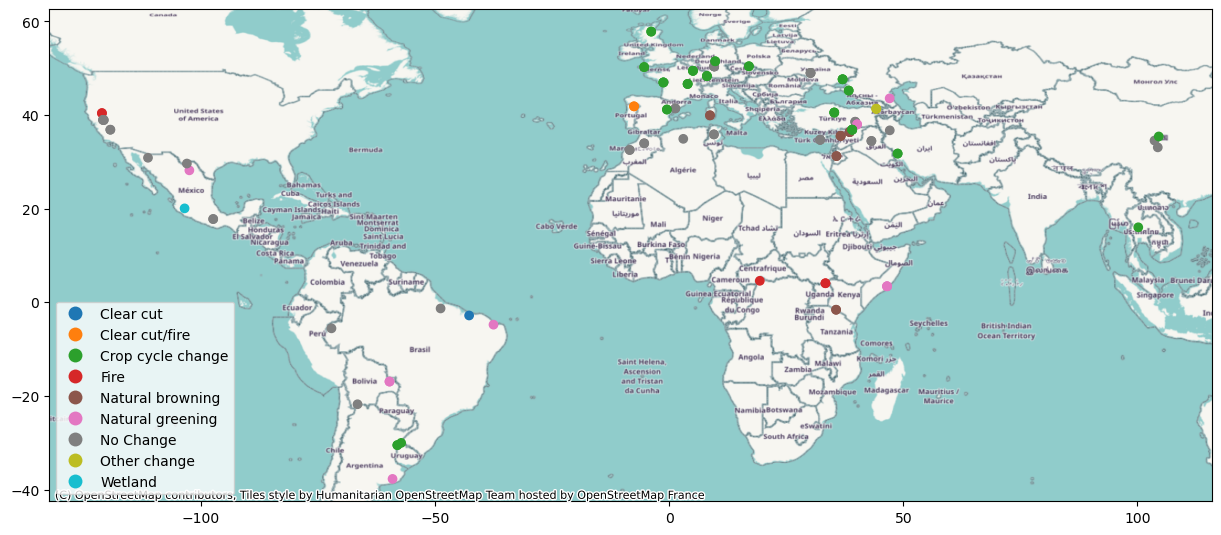

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
df_subset_final.plot(column='change_type', ax=ax, legend=True)
cx.add_basemap(ax, crs=df_site_subset.crs,zoom=3)

In [59]:
df_site_cc = df_subset_final[df_subset_final.change_type.str.lower().str.contains('clear cut')].reset_index(drop=True)
df_site_cc

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry,jpl_burst_id
0,250,VLmaj,Clear cut/fire,2022-09-03,2022-08-29,29TPG,POINT (-7.52849 41.84227),T074-157046-IW1
1,250,VLmaj,Clear cut/fire,2022-09-03,2022-08-29,29TPG,POINT (-7.52849 41.84227),T125-267168-IW1
2,288,VLmaj,Clear cut,2021-10-03,NaT,23MQS,POINT (-42.75293 -2.82839),T126-269585-IW2


In [60]:
df_rtc = pd.read_json('rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [61]:
K = 2
df_site_cc.iloc[K]

site_id                                                          288
change_label                                                   VLmaj
change_type                                                Clear cut
change_time                                      2021-10-03 00:00:00
last_observation_time                                            NaT
mgrs_tile_id                                                   23MQS
geometry                 POINT (-42.7529312671236 -2.82838978371313)
jpl_burst_id                                         T126-269585-IW2
Name: 2, dtype: object

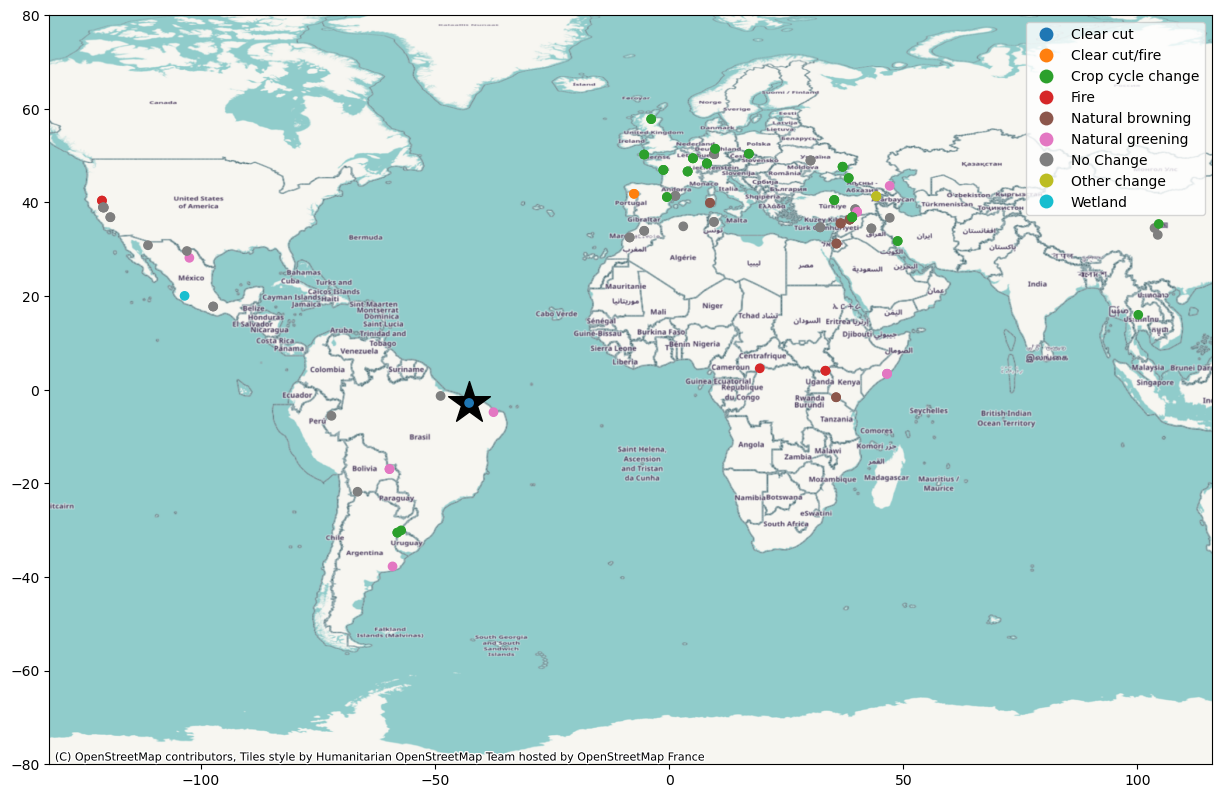

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))
df_site_cc.iloc[K: K+1].plot(ax=ax, marker='*', markersize=1000, color='black')
df_subset_final.plot(column='change_type', ax=ax, legend=True)
ax.set_ylim(-80, 80)
cx.add_basemap(ax, crs=df_site_subset.crs,zoom=3)

In [63]:
site_id = df_site_cc.site_id[K]
burst_id = df_site_cc.jpl_burst_id[K]
lon = df_site_cc.geometry[K].x
lat = df_site_cc.geometry[K].y
change_time = df_site_cc.change_time[K]
lon, lat

(-42.7529312671236, -2.82838978371313)

In [64]:
df_ts = df_rtc[df_rtc.jpl_burst_id == burst_id].reset_index(drop=True)
df_ts.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T126-269585-IW2_20201006T08334...,S1A_IW_SLC__1SDV_20201006T083340_20201006T0834...,T126-269585-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-06 08:33:40
1,OPERA_L2_RTC-S1_T126-269585-IW2_20201018T08334...,S1A_IW_SLC__1SDV_20201018T083340_20201018T0834...,T126-269585-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-18 08:33:40
2,OPERA_L2_RTC-S1_T126-269585-IW2_20201030T08334...,S1A_IW_SLC__1SDV_20201030T083340_20201030T0834...,T126-269585-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-30 08:33:40
3,OPERA_L2_RTC-S1_T126-269585-IW2_20201111T08334...,S1A_IW_SLC__1SDV_20201111T083340_20201111T0834...,T126-269585-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-11 08:33:40
4,OPERA_L2_RTC-S1_T126-269585-IW2_20201123T08334...,S1A_IW_SLC__1SDV_20201123T083340_20201123T0834...,T126-269585-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-23 08:33:40


In [42]:
url = df_ts.rtc_s1_vh_url[0]
with rasterio.open(url) as src:
    src_crs = src.crs
    
transformer = Transformer.from_crs(CRS.from_epsg(4326),
                                   src_crs, 
                                   always_xy=True)
utm_x, utm_y = transformer.transform(lon, lat)

def read_pixel_from_raster(raster_path, utm_x, utm_y) -> float:
    with rasterio.open(raster_path) as src:
        src_trans = src.transform

    row, col = rowcol(src.transform, utm_x, utm_y)
    row_m1 = max(row - 1, 0)
    col_m1 = max(col - 1, 0)
    window = Window(col_m1, row_m1, 3, 3)

    with rasterio.open(raster_path) as src:
        values = src.read(1, window=window).ravel()
    return np.nanmean(values)

In [43]:
read_pixel_from_raster(df_ts.rtc_s1_vh_url[0], utm_x, utm_y)

0.061983876

In [44]:
%%time
N = df_ts.shape[0]
def read_pixel_from_raster_p(url):
    return read_pixel_from_raster(url, utm_x, utm_y)
    
with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    vh_vals = list(tqdm(executor.map(read_pixel_from_raster_p, df_ts.rtc_s1_vh_url), total=N))
with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    vv_vals = list(tqdm(executor.map(read_pixel_from_raster_p, df_ts.rtc_s1_vv_url), total=N))

100%|███████████████| 67/67 [01:13<00:00,  1.09s/it]

CPU times: user 11.7 s, sys: 7.66 s, total: 19.3 s
Wall time: 2min 24s


In [45]:
# vh_vals = [read_pixel_from_raster(url, lon, lat) for url in tqdm(df_ts.rtc_s1_vh_url)]

In [46]:
df_ts.acq_datetime

0     2020-10-06 08:33:40
1     2020-10-18 08:33:40
2     2020-10-30 08:33:40
3     2020-11-11 08:33:40
4     2020-11-23 08:33:40
             ...         
62    2022-10-08 08:33:37
63    2022-10-20 08:33:37
64    2022-11-01 08:33:37
65    2022-11-13 08:33:37
66    2022-11-25 08:33:37
Name: acq_datetime, Length: 67, dtype: object

(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266., 19358.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01')])

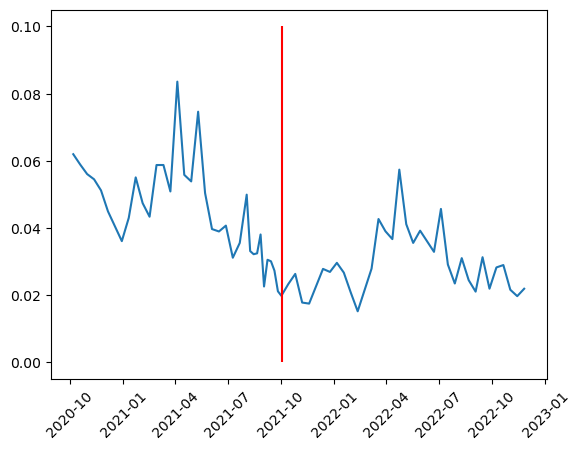

In [47]:
dts = [pd.to_datetime(dt) for dt in df_ts.acq_datetime]
plt.plot(dts, vh_vals)
plt.vlines(change_time, 0, .1, color='red')
plt.xticks(rotation=45)


(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266., 19358.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01')])

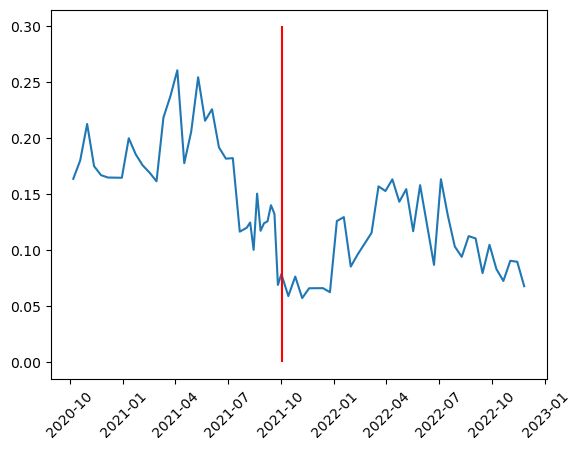

In [48]:
plt.plot(dts, vv_vals)
plt.vlines(change_time, 0, .3, color='red')
plt.xticks(rotation=45)

In [49]:
vv_series = pd.Series(vv_vals).rolling(window=3).mean()

(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266., 19358.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01')])

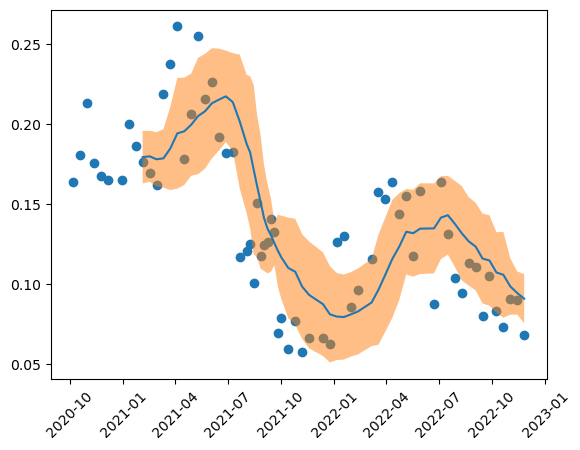

In [50]:
vv_ra = pd.Series(vv_vals, index=dts).rolling(window=10).mean()
vv_std = pd.Series(vv_vals, index=dts).rolling(window=10).std()

plt.scatter(dts, vv_vals)
plt.plot(dts, vv_ra)
plt.fill_between(dts, vv_ra - vv_std, vv_ra + vv_std, alpha=.5)

#plt.vlines(change_time, 0, .3, color='red')
plt.xticks(rotation=45)

(array([18536., 18628., 18718., 18809., 18901., 18993., 19083., 19174.,
        19266., 19358.]),
 [Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01')])

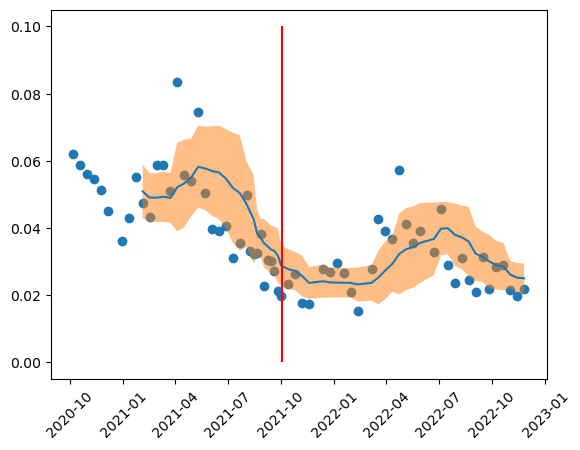

In [51]:
vh_ra = pd.Series(vh_vals).rolling(window=10).mean()
vh_std = pd.Series(vh_vals).rolling(window=10).std()

plt.scatter(dts, vh_vals)
plt.plot(dts, vh_ra)
plt.fill_between(dts, vh_ra - vh_std, vh_ra + vh_std, alpha=.5)

plt.vlines(change_time, 0, .1, color='red')
plt.xticks(rotation=45)

In [65]:
change_time_temp = change_time# + pd.Timedelta(days=80)

In [66]:
yy = pd.Series(data=vv_vals, index=dts).resample('6D').ffill()[1:]
yy_subset = yy[yy.index < change_time_temp].copy()
yy_subset

2020-10-12    0.163987
2020-10-18    0.163987
2020-10-24    0.180409
2020-10-30    0.180409
2020-11-05    0.212963
2020-11-11    0.212963
2020-11-17    0.175281
2020-11-23    0.175281
2020-11-29    0.167255
2020-12-05    0.167255
2020-12-11    0.165131
2020-12-17    0.165131
2020-12-23    0.165131
2020-12-29    0.165131
2021-01-04    0.164923
2021-01-10    0.164923
2021-01-16    0.200213
2021-01-22    0.200213
2021-01-28    0.185903
2021-02-03    0.185903
2021-02-09    0.176020
2021-02-15    0.176020
2021-02-21    0.169527
2021-02-27    0.169527
2021-03-05    0.161797
2021-03-11    0.161797
2021-03-17    0.218752
2021-03-23    0.218752
2021-03-29    0.237724
2021-04-04    0.237724
2021-04-10    0.260881
2021-04-16    0.260881
2021-04-22    0.177979
2021-04-28    0.177979
2021-05-04    0.206087
2021-05-10    0.206087
2021-05-16    0.254665
2021-05-22    0.254665
2021-05-28    0.215824
2021-06-03    0.215824
2021-06-09    0.226130
2021-06-15    0.226130
2021-06-21    0.192079
2021-06-27 

In [67]:
yy_subset.values

array([0.16398747, 0.16398747, 0.18040854, 0.18040854, 0.21296336,
       0.21296336, 0.17528085, 0.17528085, 0.16725518, 0.16725518,
       0.16513106, 0.16513106, 0.16513106, 0.16513106, 0.16492333,
       0.16492333, 0.200213  , 0.200213  , 0.18590288, 0.18590288,
       0.1760204 , 0.1760204 , 0.1695265 , 0.1695265 , 0.16179743,
       0.16179743, 0.21875188, 0.21875188, 0.23772362, 0.23772362,
       0.2608808 , 0.2608808 , 0.1779794 , 0.1779794 , 0.20608741,
       0.20608741, 0.2546653 , 0.2546653 , 0.2158237 , 0.2158237 ,
       0.22612993, 0.22612993, 0.19207901, 0.19207901, 0.18199266,
       0.18199266, 0.18244821, 0.18244821, 0.11680758, 0.11680758,
       0.12026832, 0.12494702, 0.1005475 , 0.15073231, 0.11758828,
       0.12432802, 0.126005  , 0.14041224, 0.13269824, 0.06920157],
      dtype=float32)

In [68]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
y = load_airline().to_timestamp(freq='6D')
forecaster = Prophet(  
    seasonality_mode='additive',
    #n_changepoints=1,
    #add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality=True, 
    growth='flat', 
    #seasonality_prior_scale=365, 
    daily_seasonality=False, weekly_seasonality=False)
forecaster.fit(yy_subset)  
N = (yy.index > change_time_temp).sum()
y_pred = forecaster.predict(fh=np.arange(N))  
y_unc = forecaster.predict_var(fh=np.arange(N))

14:02:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:50 - cmdstanpy - INFO - Chain [1] done processing


<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_28988/3457783567.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('$\gamma$')


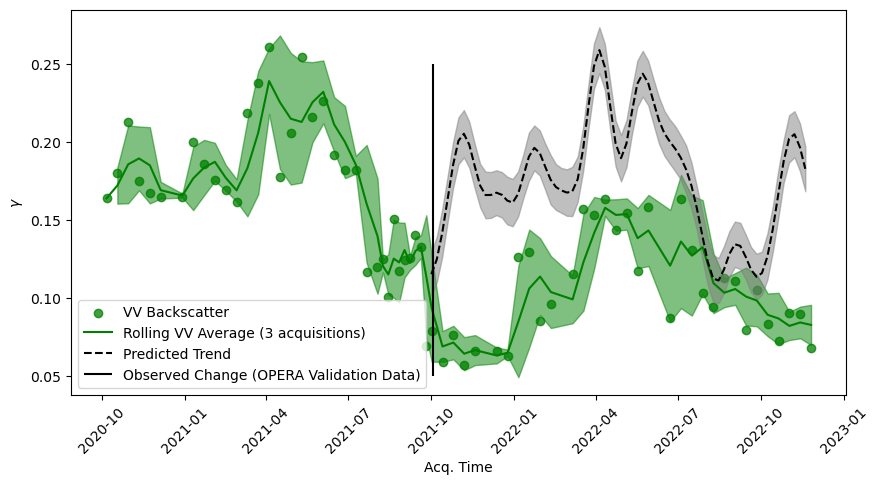

In [88]:
plt.figure(figsize=(10, 5), dpi=100)
vv_ra = pd.Series(vv_vals, index=dts).rolling(window=3, min_periods=1).mean()
vv_std = pd.Series(vv_vals, index=dts).rolling(window=3, min_periods=1).std()

plt.scatter(dts, vv_vals, color='green', alpha=.75, label='VV Backscatter')
plt.plot(dts, vv_ra, color='green', label='Rolling VV Average (3 acquisitions)')
plt.fill_between(dts, vv_ra - vv_std, vv_ra + vv_std, alpha=.5, color='green')

plt.plot(y_pred.index, y_pred, '--', color='black', label='Predicted Trend')
plt.fill_between(y_pred.index, 
                 y_pred.values - np.sqrt(y_unc.values).ravel(), 
                 y_pred.values + np.sqrt(y_unc.values).ravel(), alpha=.5, color='gray')
#plt.vlines(change_time, 0.05, .25, color='red', label ='Observed Change (Optical)')
plt.vlines(change_time_temp, 0.05, .25, color='black', label ='Observed Change (OPERA Validation Data)')

plt.xticks(rotation=45)
plt.ylabel('$\gamma$')
plt.xlabel('Acq. Time')
plt.legend(loc='lower left')

(-132.4638100448467, 115.8316878043807, -80.0, 80.0)

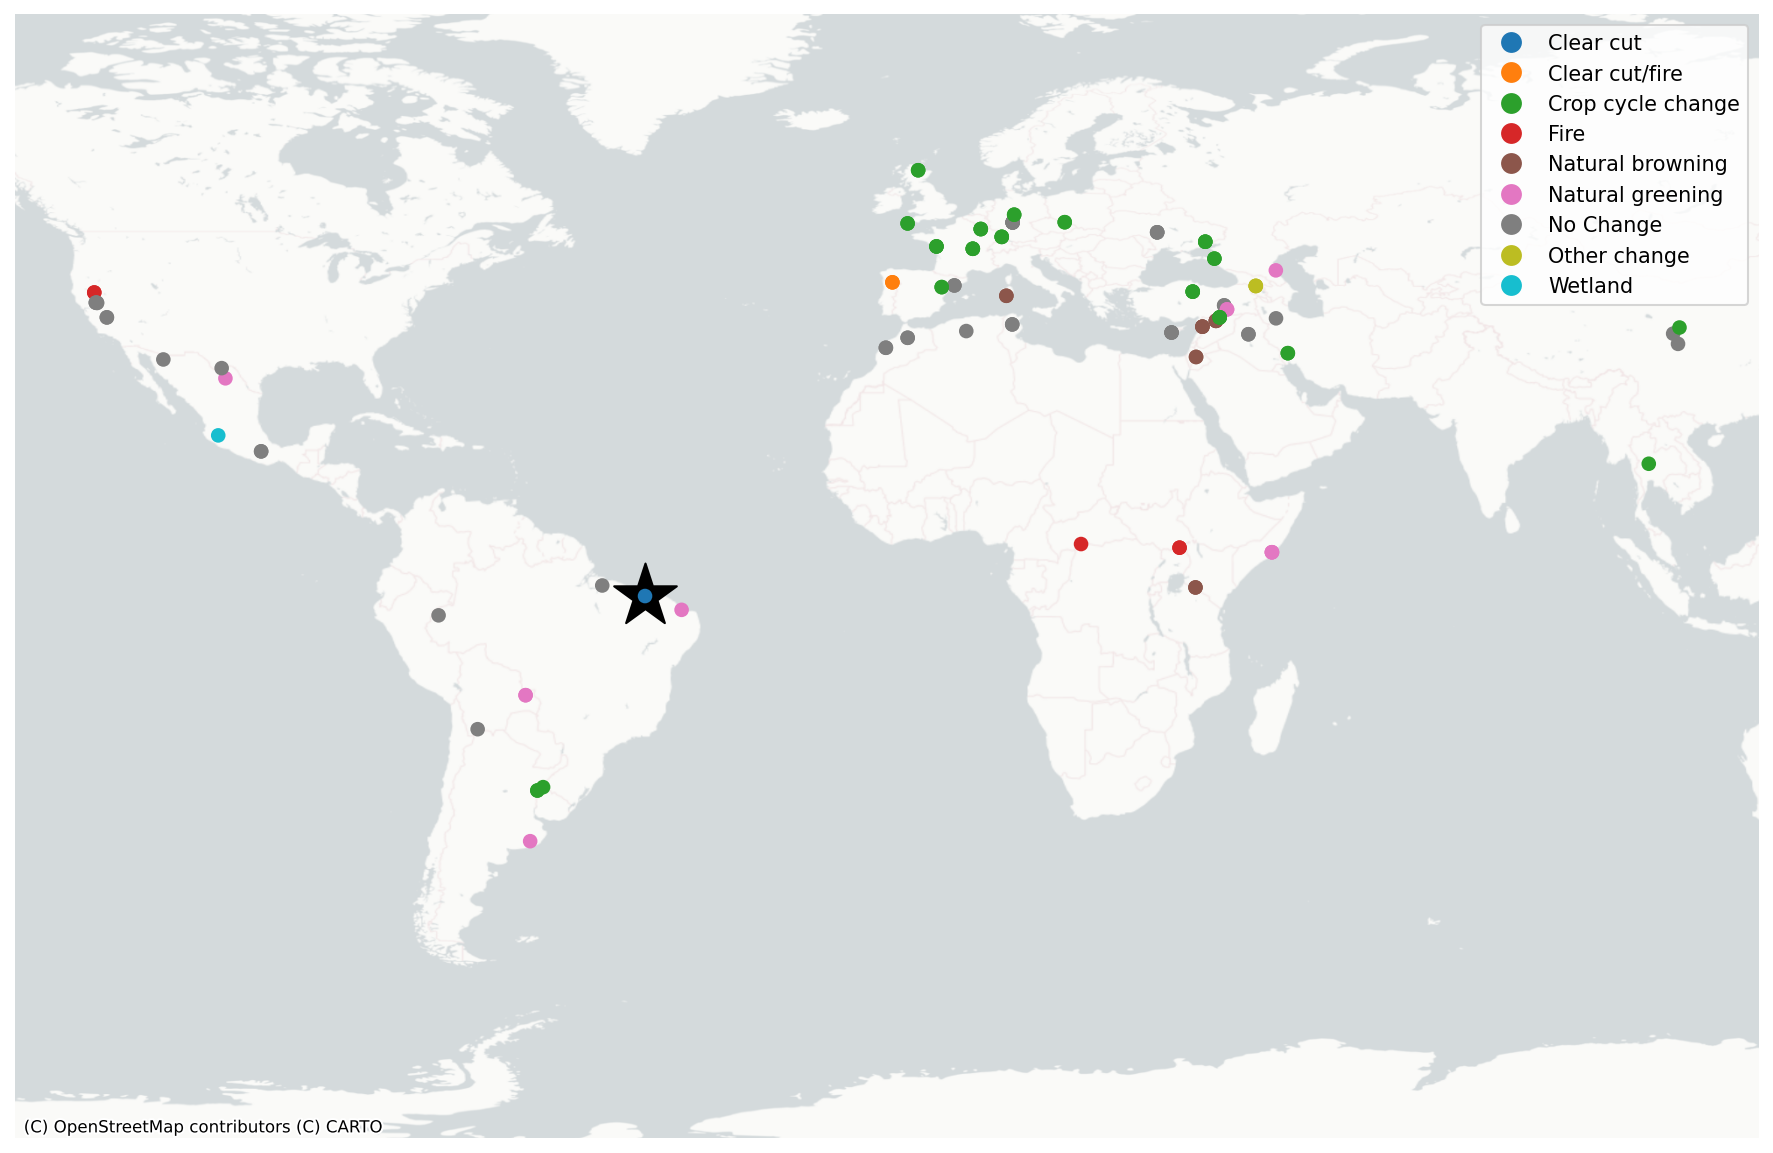

In [90]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=150)
df_site_cc.iloc[K: K+1].plot(ax=ax, marker='*', markersize=1000, color='black')
df_subset_final.plot(column='change_type', ax=ax, legend=True)
ax.set_ylim(-80, 80)
cx.add_basemap(ax, 
               crs=df_site_subset.crs,zoom=3, 
               source=cx.providers.CartoDB.PositronNoLabels)
ax.axis('off')